# Stuklov Dmitry - Week7

In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
data_train=pd.read_csv("data/features.csv",index_col="match_id")
data_train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


## Подход 1: Градиентный бустинг "в лоб"

### 1. Посчитаем таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалим признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке)

In [3]:
data_train.drop(["duration","tower_status_radiant","tower_status_dire","barracks_status_radiant","barracks_status_dire"],axis=1,inplace=True)

### 2. (1) Проверим выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Выясним, много ли пропусков в данных?

In [4]:
countna=len(data_train)-data_train.count()
countna[countna>0].sort_values(ascending=False)/len(data_train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

### 2. (2) Запишем названия признаков, имеющих пропуски, и попробуем для любых двух из них дать обоснование, почему их значения могут быть пропущены

* **first_blood_player2 (второй игрок, причастный к событию)**: Первое убийство может быть совершено одним игроком, это явление встречается довольно часто и возникает в 45% случаев.
* **first_blood_time (игровое время первой крови)**: В 20% случаев первой крови нет на протяжении первых 5 минут игры.
* **first_blood_team (команда, совершившая первую кровь)**: Аналогично **first_blood_time**, процент тот же (20%).
* **first_blood_player1 (игрок, причастный к событию)**: Аналогично **first_blood_time**, процент тот же (20%).

### 3. Заменим пропуски на нули с помощью функции fillna()

In [5]:
data_train.fillna(0,inplace=True)

### 4. Запишем название столбца, который содержит целевую переменную

In [6]:
print("Название столбца, который содержит целевую переменную: radiant_win")
X_train=data_train.drop("radiant_win",axis=1)
y_train=data_train["radiant_win"]

Название столбца, который содержит целевую переменную: radiant_win


### 5. Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки"
### 5. (1) Зафиксируем генератор разбиений для кросс-валидации по 5 блокам (KFold), не забыв перемешать при этом выборку (shuffle=True) 
### 5. (2) Оценим качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуем при этом разное количество деревьев

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
def Score_1(X, y, n_estimators):
    time_start=datetime.datetime.now()
    model=GradientBoostingClassifier(n_estimators = n_estimators, random_state = 241)
    val_scores=cross_val_score(estimator = model, cv = cv, scoring = "roc_auc", X = X, y = y)
    time_elapsed=datetime.datetime.now()-time_start
    score_mean=np.mean(val_scores)
    print('n_estimators = {}, score_mean = {}, time_elapsed = {}, '.format(n_estimators, score_mean, time_elapsed))
    return score_mean, time_elapsed

n_estimators = 10, score_mean = 0.6648506879750012, time_elapsed = 0:00:20.688387, 
n_estimators = 20, score_mean = 0.6824618768044435, time_elapsed = 0:00:48.315215, 
n_estimators = 30, score_mean = 0.6900064710388155, time_elapsed = 0:01:15.754725, 
n_estimators = 50, score_mean = 0.6974943609466162, time_elapsed = 0:02:06.335365, 
n_estimators = 100, score_mean = 0.7062211835407148, time_elapsed = 0:04:26.697540, 
n_estimators = 250, score_mean = 0.7159103221517404, time_elapsed = 0:10:03.820909, 


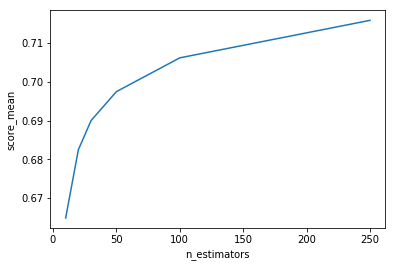

In [8]:
Scores={}
Times={}
for n in [10,20,30,50,100,250]:
    Scores[n],Times[n]=Score_1(X_train,y_train,n)
plt.plot(Scores.keys(),Scores.values())
plt.xlabel('n_estimators')
plt.ylabel('score_mean')
plt.show()

### 5. (3) Долго ли настраивались классификаторы?

In [9]:
print('Кросс-валидация для градиентного бустинга с 30 деревьями заняла {}.\nПоказатель метрики качества AUC-ROC в таком случае равен {}.'.format(Times[30], Scores[30]))

Кросс-валидация для градиентного бустинга с 30 деревьями заняла 0:01:15.754725.
Показатель метрики качества AUC-ROC в таком случае равен 0.6900064710388155.


### 5. (4) Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?
* Увеличение количества деревьев увеличивает также показатель метрики AUC-ROC, приближая его к 0.72. Для того, чтобы достичь большего качества, стоит использовать более 30 деревьев. Для ускорения обучения можно использовать не всю целиком выборку, а лишь некоторое ее подмножество: например, половину объектов. Можно также уменьшить и max_depth (глубину деревьев)

## Подход 2: Логистическая регрессия

### 1. (1) Оценим качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга

In [10]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [11]:
def Score_2(X, y, n):
    C=10.0**n
    time_start=datetime.datetime.now()
    model=LogisticRegression(C=C,random_state=42)
    score_mean=cross_val_score(model,X,y,cv=cv,scoring="roc_auc",n_jobs=-1).mean()
    time_elapsed=datetime.datetime.now()-time_start
    print('C = {}, score_mean = {}, time_elapsed = {}, '.format(C,score_mean,time_elapsed))
    Scores[n]=score_mean
    return score_mean
def Best_score(Scores):
    Score_best=max(Scores,key=Scores.get)
    print("Наилучшее значение AUC-ROC получается при C = {} и оно равно {}".format(10**Score_best,Scores[Score_best]))

C = 1e-05, score_mean = 0.6951616854636575, time_elapsed = 0:00:09.125994, 
C = 0.0001, score_mean = 0.7113577471434336, time_elapsed = 0:00:12.393966, 
C = 0.001, score_mean = 0.7163635378209221, time_elapsed = 0:00:17.020192, 
C = 0.01, score_mean = 0.7165502697259141, time_elapsed = 0:00:18.054543, 
C = 0.1, score_mean = 0.7165271486657933, time_elapsed = 0:00:15.288943, 
C = 1.0, score_mean = 0.7165226003626438, time_elapsed = 0:00:15.318242, 
C = 10.0, score_mean = 0.7165222888959446, time_elapsed = 0:00:15.486652, 
C = 100.0, score_mean = 0.7165222952575674, time_elapsed = 0:00:15.516486, 
C = 1000.0, score_mean = 0.7165223227963707, time_elapsed = 0:00:14.533939, 
C = 10000.0, score_mean = 0.7165223270325809, time_elapsed = 0:00:20.730987, 
C = 100000.0, score_mean = 0.716522331269126, time_elapsed = 0:00:20.757450, 


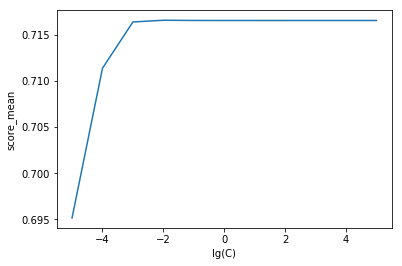

In [12]:
Scores = {}
for n in range(-5, 6):
    Scores[n]=Score_2(X_train,y_train,n)
plt.plot(Scores.keys(),Scores.values())
plt.xlabel('lg(C)')
plt.ylabel('score_mean')
plt.show()

### 1. (2) Подберём при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось?

In [13]:
Best_score(Scores)

Наилучшее значение AUC-ROC получается при C = 0.01 и оно равно 0.7165502697259141


### 1. (3) Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

* Это можно сравнивать с градиентным бустингом по 250 деревьям, однако при этом, логистическая регрессия работает гораздо быстрее. То, что разница с градиентным бустингом отсутствует, может говорить о том, что связь между данными фичами и целевой переменной является линейной. Отсюда следует, что такая связь хорошо описывается логистической регрессией, исключая таким образом надобность более сложных моделей

### 2. (1) Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберём их из выборки, и проведём кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации

In [14]:
Heroes=[f"r{M}_hero" for M in range (1, 6)]+[f"d{M}_hero" for M in range (1, 6)]
Cat_columns=["lobby_type"]+Heroes
X_train.drop(Cat_columns, axis=1, inplace=True)

C = 1e-05, score_mean = 0.6951001913436113, time_elapsed = 0:00:07.962356, 
C = 0.0001, score_mean = 0.7113391458629872, time_elapsed = 0:00:09.543395, 
C = 0.001, score_mean = 0.7163757999081172, time_elapsed = 0:00:16.346232, 
C = 0.01, score_mean = 0.7165593885630225, time_elapsed = 0:00:20.142523, 
C = 0.1, score_mean = 0.7165342403465319, time_elapsed = 0:00:18.243640, 
C = 1.0, score_mean = 0.7165303634514961, time_elapsed = 0:00:13.958276, 
C = 10.0, score_mean = 0.7165299715025929, time_elapsed = 0:00:14.337646, 
C = 100.0, score_mean = 0.7165298910060073, time_elapsed = 0:00:17.542219, 
C = 1000.0, score_mean = 0.7165298888849942, time_elapsed = 0:00:22.745801, 
C = 10000.0, score_mean = 0.716529884649503, time_elapsed = 0:00:16.584974, 
C = 100000.0, score_mean = 0.716529884649503, time_elapsed = 0:00:17.087892, 


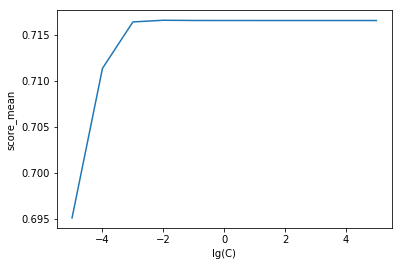

In [15]:
Scores = {}
for n in range(-5, 6):
    Scores[n]=Score_2(X_train,y_train,n)
plt.plot(Scores.keys(),Scores.values())
plt.xlabel('lg(C)')
plt.ylabel('score_mean')
plt.show()

### 2. (2) Изменилось ли качество? Чем вы можете это объяснить?

In [16]:
Best_score(Scores)

Наилучшее значение AUC-ROC получается при C = 0.01 и оно равно 0.7165593885630225


* Удаление категориальных признаков не оказало влияния на качество предсказания. Отсюда можно сделать вывод о том, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.

### 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясним из данных, сколько различных идентификаторов героев существует в данной игре (может пригодиться фукнция unique или value_counts)

In [17]:
Uniq_heroes=np.unique(data_train[Heroes].values.ravel())
H=max(Uniq_heroes)
print(f"Количество уникальных героев в игре: {len(Uniq_heroes)}, максимальный ID героя: {H}.")

Количество уникальных героев в игре: 108, максимальный ID героя: 112.


### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже мы найдём код, который выполняет данное преобразование. Добавим полученные признаки к числовым, которые мы использовали во втором пункте данного этапа

In [18]:
def Hero_side(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], H))
    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1
    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(H)])
X_pick = Hero_side(data_train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. (1) Проведём кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации

In [19]:
X_train=pd.concat([X_train,X_pick],axis=1)

C = 1e-05, score_mean = 0.6992162157577898, time_elapsed = 0:00:07.796371, 
C = 0.0001, score_mean = 0.7250715006210953, time_elapsed = 0:00:10.490856, 
C = 0.001, score_mean = 0.7463341511009906, time_elapsed = 0:00:13.815467, 
C = 0.01, score_mean = 0.7517377411686084, time_elapsed = 0:00:21.566288, 
C = 0.1, score_mean = 0.7519475239468273, time_elapsed = 0:00:27.921011, 
C = 1.0, score_mean = 0.751927599168204, time_elapsed = 0:00:27.749143, 
C = 10.0, score_mean = 0.7519252574540074, time_elapsed = 0:00:27.467903, 
C = 100.0, score_mean = 0.7519246917068976, time_elapsed = 0:00:27.389779, 
C = 1000.0, score_mean = 0.7519246154149967, time_elapsed = 0:00:28.234189, 
C = 10000.0, score_mean = 0.7519245624536606, time_elapsed = 0:00:28.489590, 
C = 100000.0, score_mean = 0.7519246069397615, time_elapsed = 0:00:27.876536, 


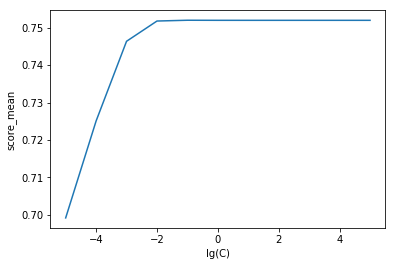

In [20]:
Scores = {}
for n in range(-5, 6):
    Scores[n]=Score_2(X_train,y_train,n)
plt.plot(Scores.keys(),Scores.values())
plt.xlabel('lg(C)')
plt.ylabel('score_mean')
plt.show()

### 5. (2) Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [21]:
Best_score(Scores)

Наилучшее значение AUC-ROC получается при C = 0.1 и оно равно 0.7519475239468273


* После добавления "мешка слов" качество по героям улучшилось. Причиной этому является то, что вместо отсутствия данных о героях или случайного шума из id, для построения предсказания, мы имеем осмысленную разреженную матрицу

### 6. Построим предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедимся, что предсказанные вероятности - адекватные, т.е. находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

In [22]:
Model=LogisticRegression(C=0.1,random_state=42)
Model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
data_test = pd.read_csv("data/features_test.csv", index_col="match_id")
data_test.fillna(0, inplace=True)

In [24]:
X_test=pd.DataFrame(scaler.transform(data_test),index=data_test.index,columns=data_test.columns)
X_test.drop(Cat_columns,axis=1,inplace=True)
X_test=pd.concat([X_test,Hero_side(data_test)],axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
Predictions = Model.predict_proba(X_test)[:, 1]
Result_table = pd.DataFrame({'radiant_win': Predictions}, index = data_test.index)
Result_table.index.name = 'match_id'
Result_table.head()

,radiant_win
match_id,
6,0.823940
7,0.752952
10,0.188062
13,0.861663
16,0.240156


In [26]:
Predict_series = pd.Series(Predictions)
Predict_series.describe()

count    17177.000000
mean         0.517025
std          0.220954
min          0.008429
25%          0.346069
50%          0.522146
75%          0.691689
max          0.996371
dtype: float64

In [27]:
print("Минимальное и максимальное значение прогноза на тестовой выборке:\nmin = {}, max = {}".format(Result_table['radiant_win'].min(),Result_table['radiant_win'].max()))

Минимальное и максимальное значение прогноза на тестовой выборке:
min = 0.008429087385118808, max = 0.9963708703509884
